In [1]:
import os
import torch
import gc
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from transformers import pipeline, BertTokenizer, TFBertForSequenceClassification, DetrImageProcessor, DetrForObjectDetection
from PIL import Image
from diffusers import StableDiffusionPipeline
from huggingface_hub import login

2025-02-08 13:21:28.949561: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-08 13:21:29.042916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739017289.083950   16905 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739017289.097705   16905 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 13:21:29.180036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
tf.config.set_visible_devices([], 'GPU')

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Crecimiento de memoria configurado para las GPUs.")
    except RuntimeError as e:
        print(f"Error al configurar crecimiento de memoria: {e}")

Crecimiento de memoria configurado para las GPUs.


# EJERCICIOS

## EJERCICIO 1
Utiliza un modelo preentrenado de Hugging Face que clasifique textos en neutral y subjetivo y clasifica las siguientes opiniones:

* "I think the new city park is a great addition to the neighborhood. It offers a lot of green space and is a great place for families to spend time outdoors."

* "The customer service at the restaurant was disappointing. We had to wait over an hour just to get our drinks, and the staff seemed uninterested in helping us."

* "This book is just okay. It's not the best I've read, but it's not the worst either. The plot is somewhat predictable, but the characters are somewhat interesting."

* "The local library has extended its operating hours on weekends. It is now open from 9 a.m. to 7 p.m. on Saturdays and Sundays"

El resultado lo tiene que mostrar  de la siguiente forma:

* Texto: XXX 
* Clasificación: Y con una confianza del X%

Device set to use cuda:0


Texto: I think the new city park is a great addition to the neighborhood. It offers a lot of green space and is a great place for families to spend time outdoors.
Clasificación: SUBJECTIVE, con una confianza del 89.20%

Texto: The customer service at the restaurant was disappointing. We had to wait over an hour just to get our drinks, and the staff seemed uninterested in helping us.
Clasificación: SUBJECTIVE, con una confianza del 81.92%

Texto: This book is just okay. It's not the best I've read, but it's not the worst either. The plot is somewhat predictable, but the characters are somewhat interesting.
Clasificación: SUBJECTIVE, con una confianza del 87.63%

Texto: The local library has extended its operating hours on weekends. It is now open from 9 a.m. to 7 p.m. on Saturdays and Sundays
Clasificación: NEUTRAL, con una confianza del 97.11%



/home/iabd/anaconda3/envs/ia_gpu312/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## EJERCICIO 2
Traduce el siguiente texto del inglés al español usando un modelo preentrenado de Hugging Face: "The achievements of artificial intelligence are impressive."

Device set to use cuda:0


Texto traducido: Los logros de la inteligencia artificial son innegables.


## EJERCICIO 3
Genera un texto continuando la siguiente frase: "Los logros de la inteligencia artificial..."

Usa gpt2

## EJERCICIO 4
Entrena un modelo de análisis de sentimientos en un pequeño conjunto de datos personalizado usando un modelo de Hugging Face. Supongamos que tienes el siguiente conjunto de datos (evidentemente con este conjunto de datos tan pequeño no vamos a ningún lado, se trata de simular el proceso):

* "I enjoy playing football.", Positivo
* "The restaurant had poor service.", Negativo
* "Such a beautiful day outside!", Positivo

Si quieres puedes usar el modelo bert-base-uncased

Los pasos generales que puedes seguir son:
* Prepara los datos de entrenamiento (X e y).
* Carga un modelo preentrenado de Transformers y su tokenizador.
* Preprocesa los datos para que sean compatibles con el modelo.
* Compila el modelo con una función de pérdida y un optimizador.
* Entrena el modelo con los datos.
* Evalúa el modelo con algunos datos ("I enjoy playing basketboall.", Positivo y "I hate rainning days.", Negativo).
* Predice nuevos datos ("The restaurant had a good service.")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


I0000 00:00:1739017325.267678   17069 service.cc:148] XLA service 0x7b58300da0c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739017325.267935   17069 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-02-08 13:22:05.301354: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-08 13:22:05.301407: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739017325.399513   17069 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 18s 18s/step - loss: 0.5780 - accuracy: 0.6667
Epoch 2/3
1/1 [==============================] - 0s 139ms/step - loss: 0.4974 - accuracy: 1.0000
Epoch 3/3
1/1 [==============================] - 2s 2s/step - loss: 0.7392 - accuracy: 0.5000
Evaluación - Pérdida: 0.7391679883003235, Precisión: 0.5
1/1 [==============================] - 2s 2s/step
El sentimiento predicho para el texto 'The restaurant had a good service.' es: Negativo


## EJERCICIO 5
Utiliza un modelo preentrenado de Hugging Face para generar una descripción (caption) para una imagen dada.

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.48.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

Descripción generada: a woman sitting at a table with a laptop 


## EJERCICIO 6
Elige un modelo de detcción de objetos de Hugging Face y aplícalo a una imagen.

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


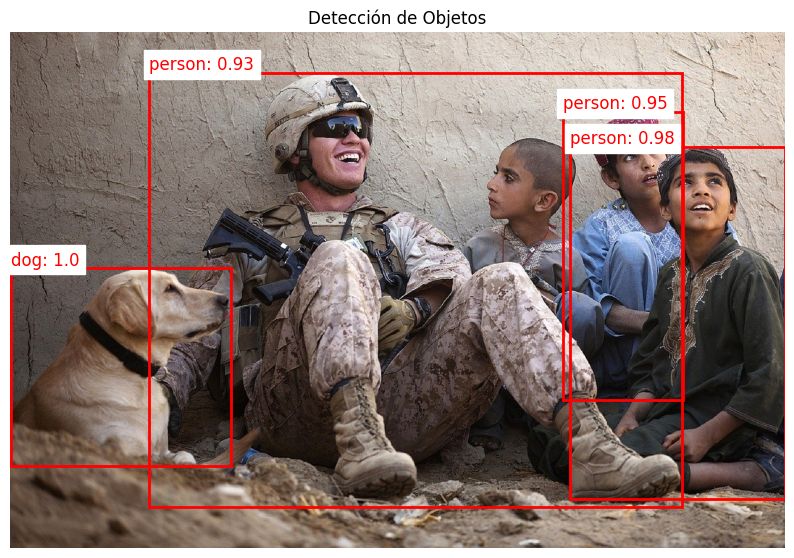

## EJERCICIO 7
Genera un texto usando un modelo de generción de texto (gpt2).
Usa el texto creado como entrada para un modelo de generación de imágenes (stable-diffusion).

El texto de entrada para el primer modelo va a ser

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Texto generado: A futuristic city with flying cars and neon lights.

The pilot of a car park at a South African industrial park is set to be charged with


## EJERCICIO 8 (OPCIONAL)
Encadena con sentido tres modelos de Hugging Face para realizar una tarea de NLP, una de visión y una de generación de imágenes.